In [ ]:
'''
2/23 1.0 完成基本计算流程
2/24 1.1 可视化中间结果
3/17 2.0 结构变化=>64m
3/18 3.0 代码重构
3/25 4.0 更改力每次移动为0.1m
3/26 4.1 实现zk活载
4/2  5.0 代码重构
4/7  5.1 支持160m桥
4/8  5.2 增加64m, 160m桥子类
'''
'''
TODO:
- get_units_axial_forces_moment需检查和self.units顺序是否对应
- get_one_unit_axial_force_moment中get_u_and_v中node_num应该与units.keys()比较而不是bc_nodes_nums
- zk活载修改
'''

### 导入模块

In [2]:
%load_ext autoreload
%autoreload 2

from bridge import Bridge_64, Bridge_160

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 输入参数

In [3]:
# 常量
E = 21 * 10**10           # 杨氏模量 (Pa)
P = 1                     # 外力    (kN)
h = 21.3                  # 恒载    (kN)

In [52]:
gamma_d = 1              
gamma_t = 1
gamma_n = None
sigma_0 = 110300

### 载入数据

In [4]:
path = '/Users/nerd/Desktop/afeng-code/data/'
bridge_len = 160

if bridge_len == 64:
    bridge = Bridge_64()
    bottom_chord_nodes_nums = [1, 3, 5, 7, 9, 11, 13, 15, 16]  # 下弦杆节点编号

elif bridge_len == 160:
    bridge = Bridge_160()
    # [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 40]
    bottom_chord_nodes_nums = list(range(1, 40, 2)) + [40]

bridge.load_data(path)
bridge.load_params(E=E, P=P, h=h, bottom_chord_nodes_nums=bottom_chord_nodes_nums)

## 计算总体刚度矩阵

In [5]:
bridge.K

array([[ 5.594e+08,  2.133e+08, -1.551e+08, ...,  0.000e+00,  0.000e+00,
         0.000e+00],
       [ 2.133e+08,  2.933e+08, -2.133e+08, ...,  0.000e+00,  0.000e+00,
         0.000e+00],
       [-1.551e+08, -2.133e+08,  8.527e+08, ...,  0.000e+00,  0.000e+00,
         0.000e+00],
       ...,
       [ 0.000e+00,  0.000e+00,  0.000e+00, ...,  2.940e+08,  0.000e+00,
         0.000e+00],
       [ 0.000e+00,  0.000e+00,  0.000e+00, ...,  0.000e+00,  4.865e+08,
        -1.131e+08],
       [ 0.000e+00,  0.000e+00,  0.000e+00, ...,  0.000e+00, -1.131e+08,
         1.555e+08]])

In [6]:
bridge.K.shape

(80, 80)

In [72]:
bridge.bottom_chord_nodes_nums

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 40]

## 计算下弦杆结点竖向位移

In [18]:
bridge.get_nodes_vdisps()

Vertical displacements of all nodes saved.


In [19]:
bridge.reduced_K.shape

(76, 76)

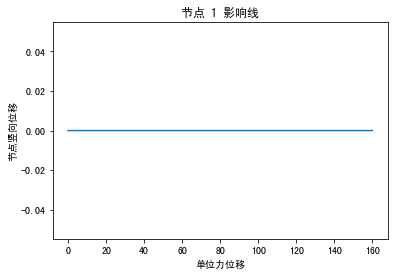

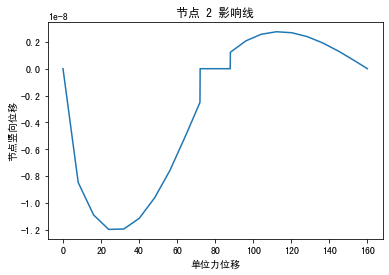

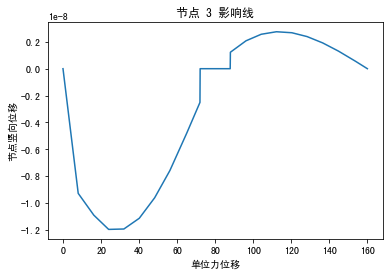

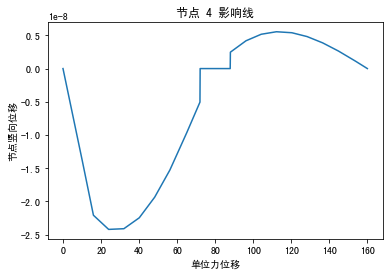

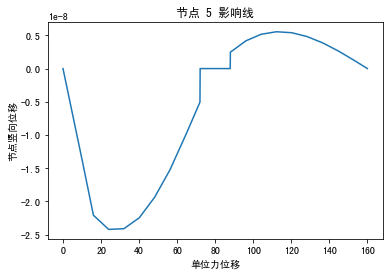

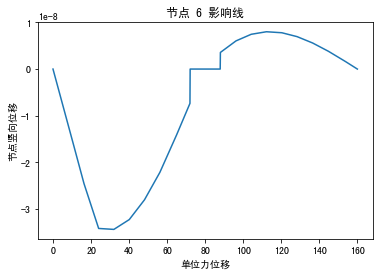

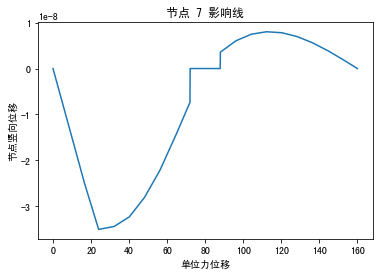

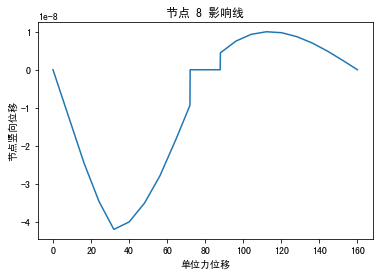

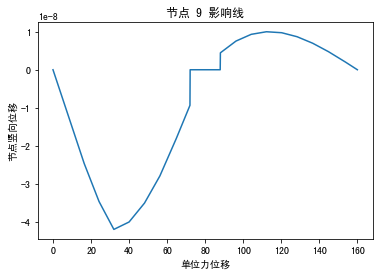

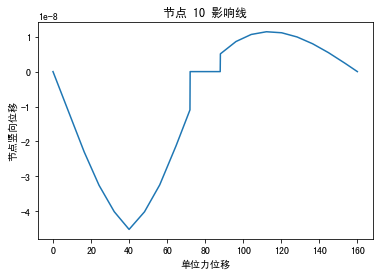

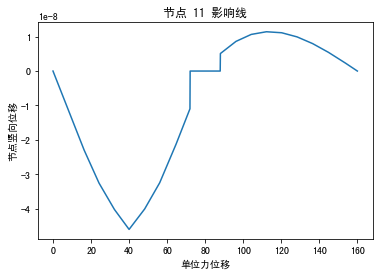

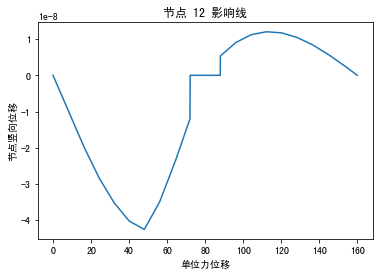

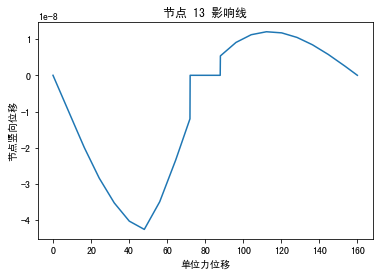

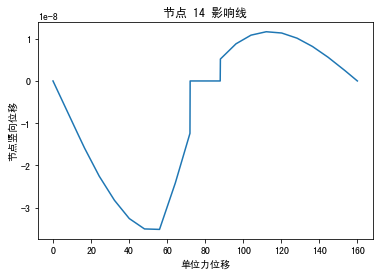

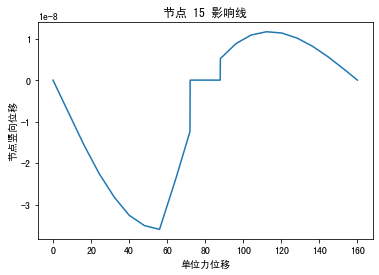

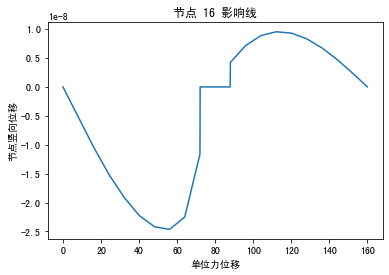

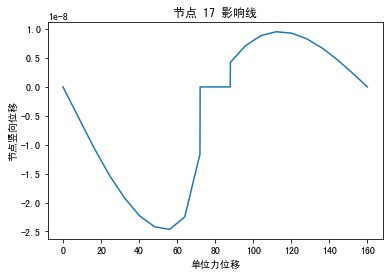

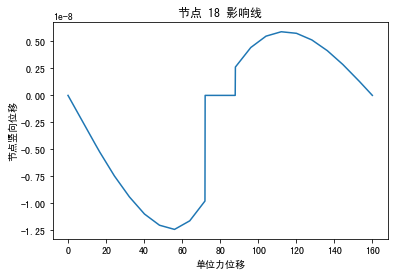

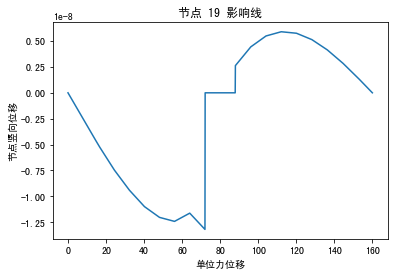

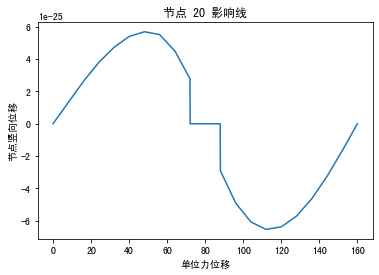

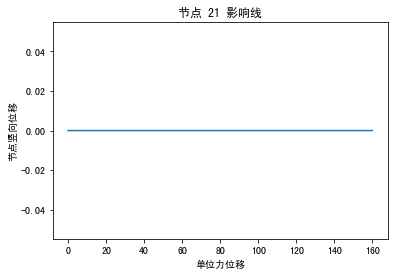

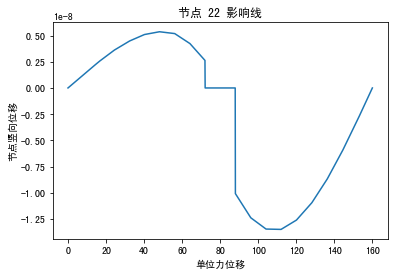

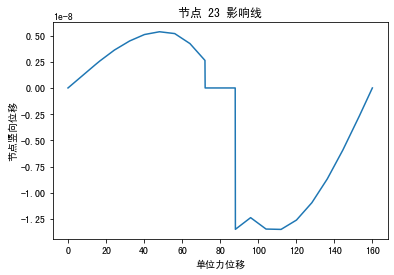

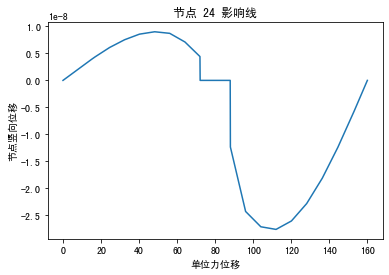

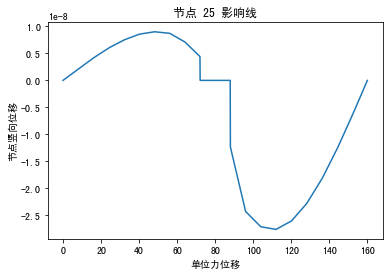

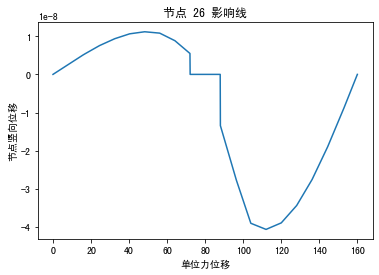

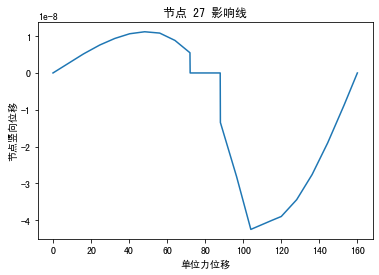

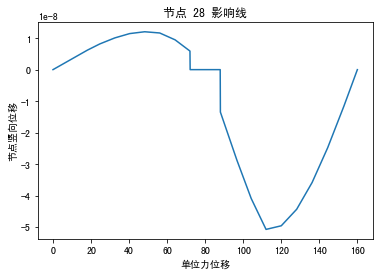

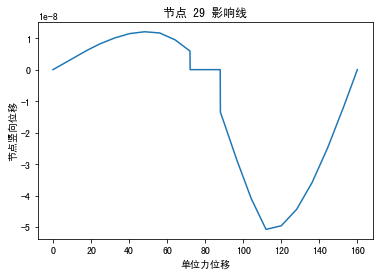

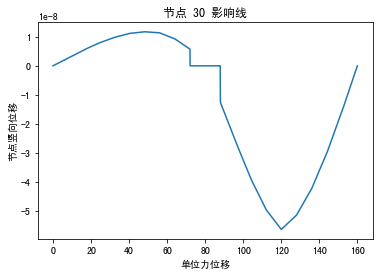

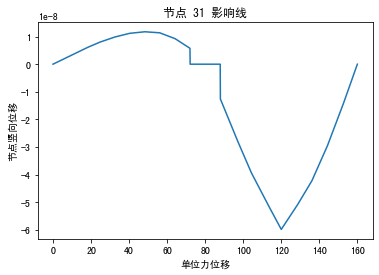

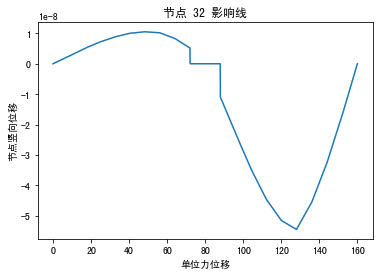

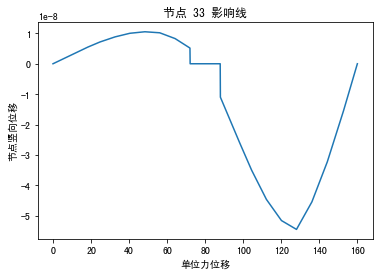

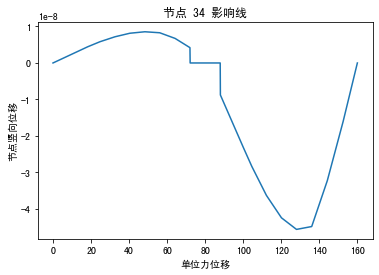

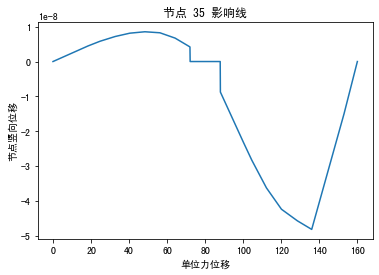

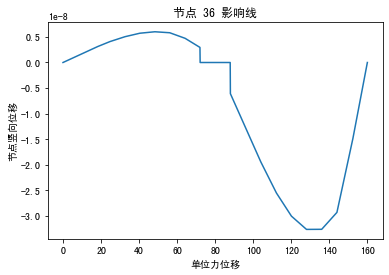

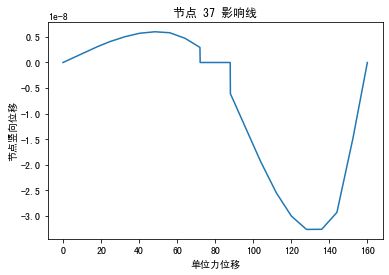

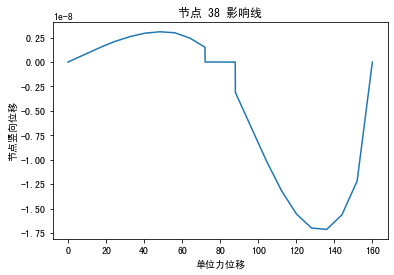

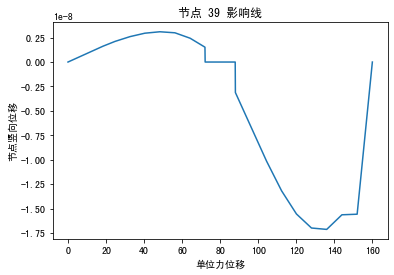

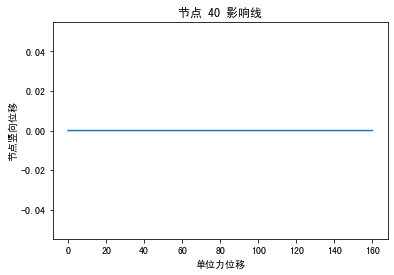

In [20]:
bridge.show_nodes_vdisps()

## 计算轴力

In [24]:
bridge.get_units_axial_forces()

Axial forces of all units saved.


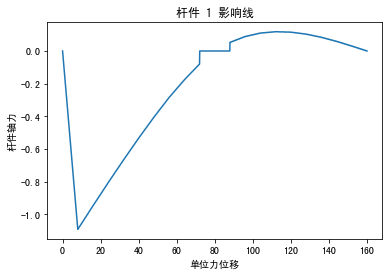

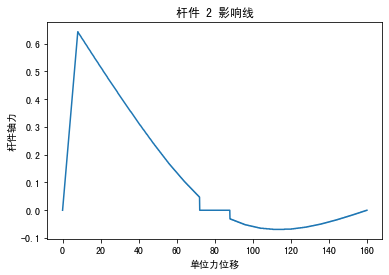

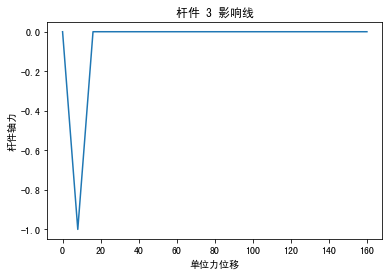

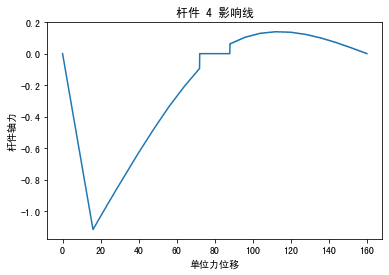

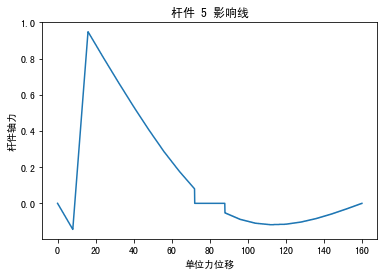

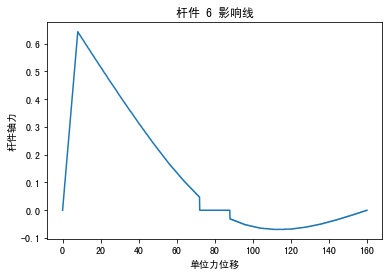

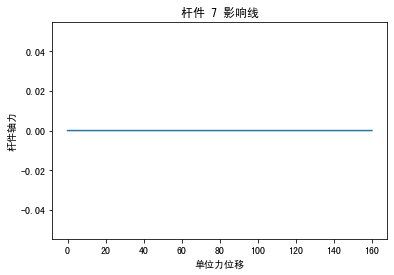

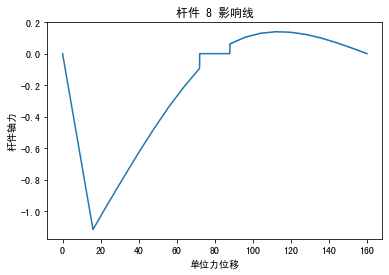

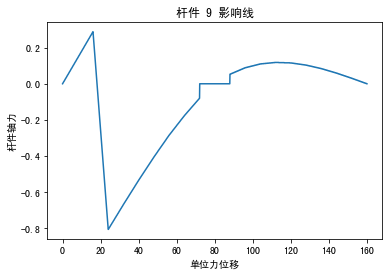

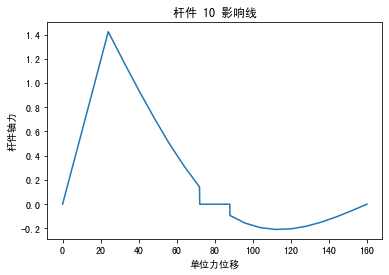

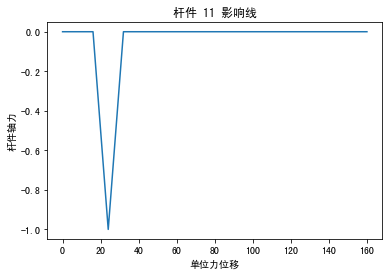

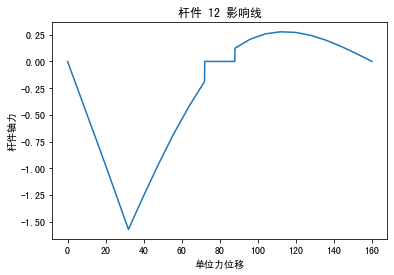

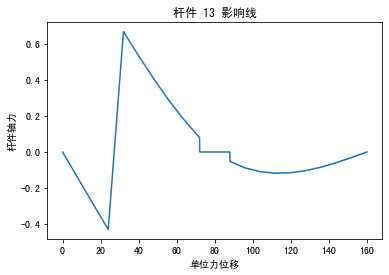

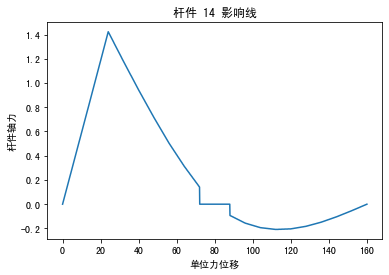

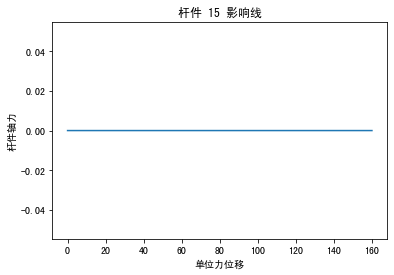

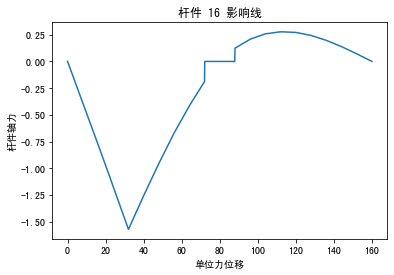

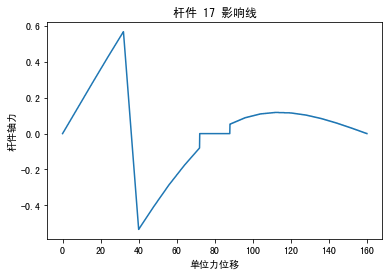

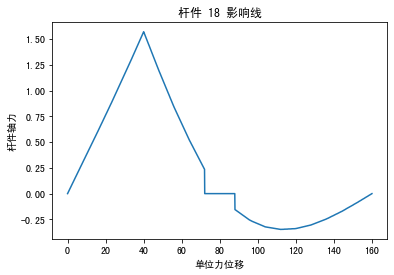

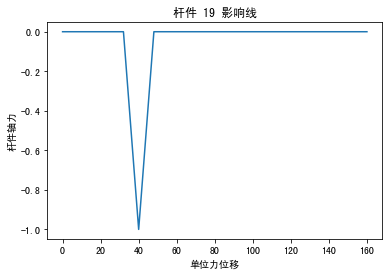

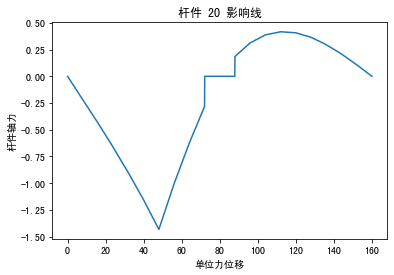

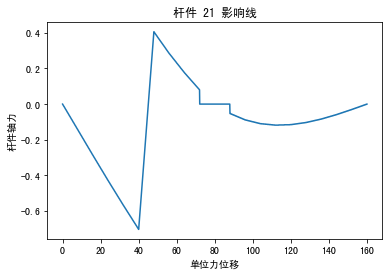

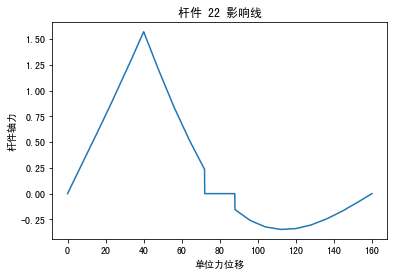

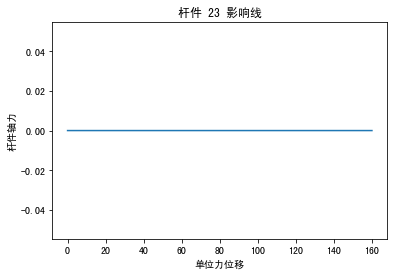

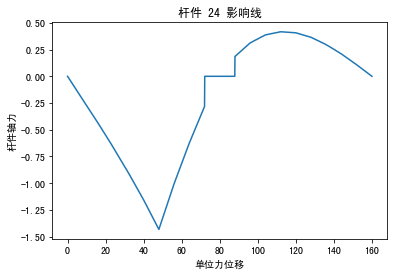

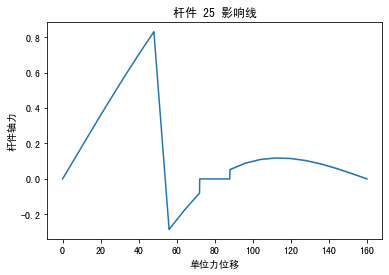

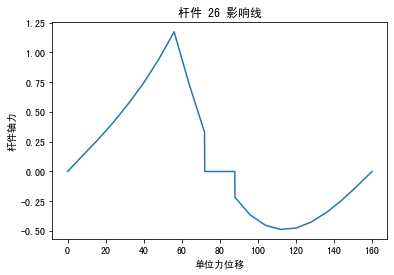

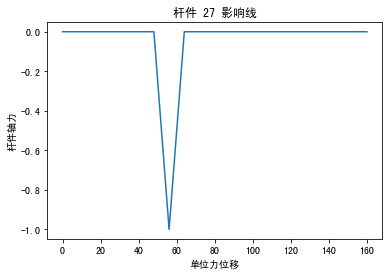

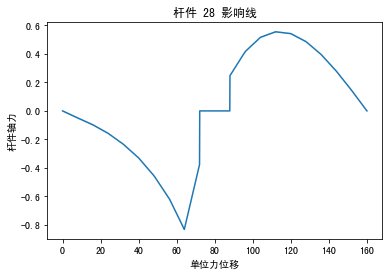

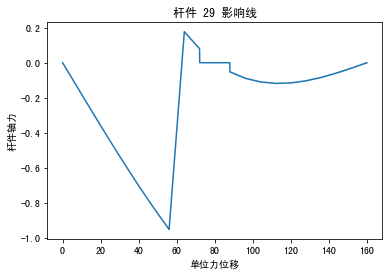

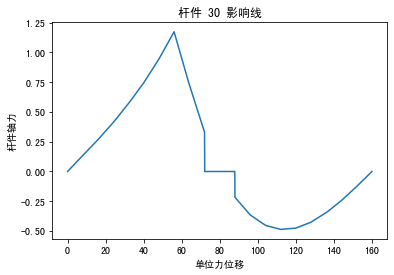

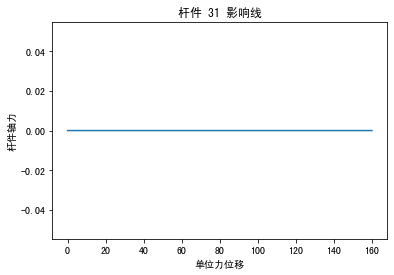

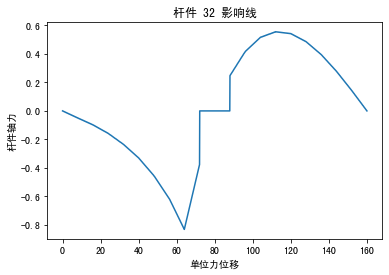

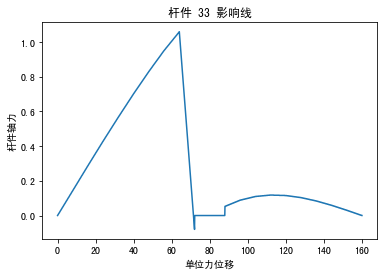

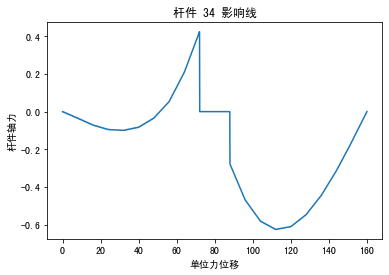

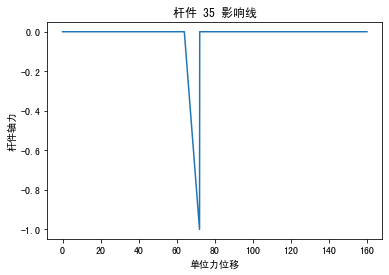

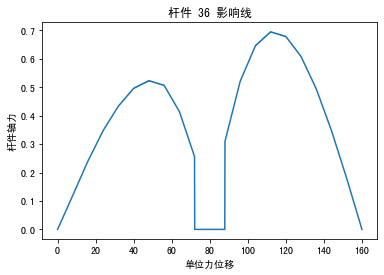

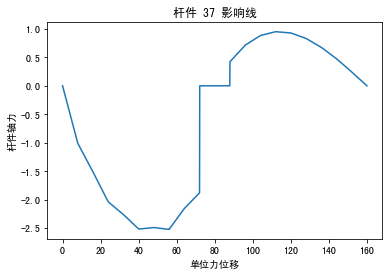

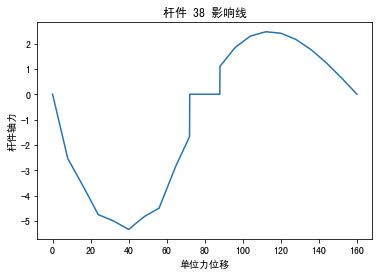

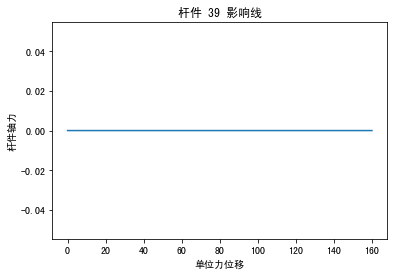

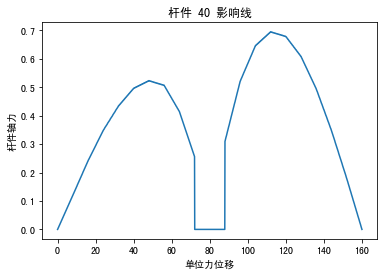

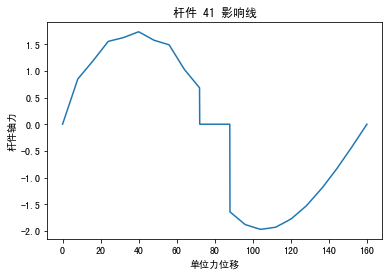

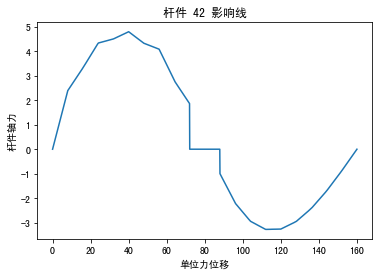

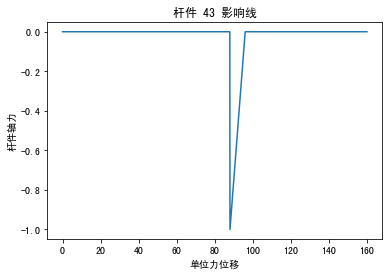

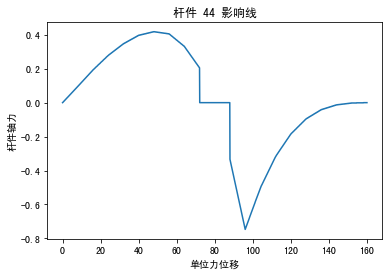

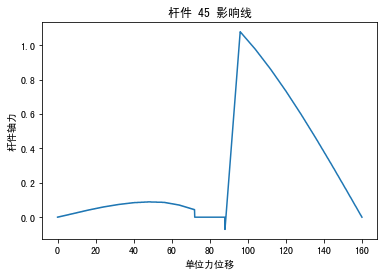

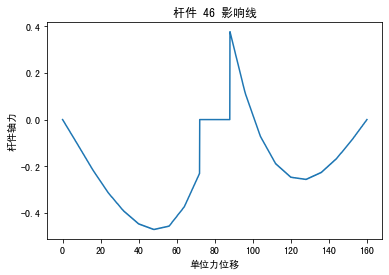

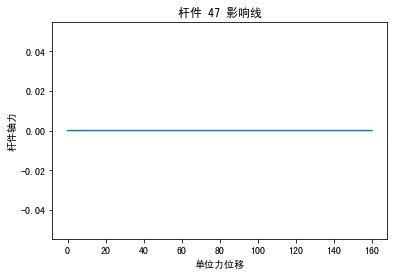

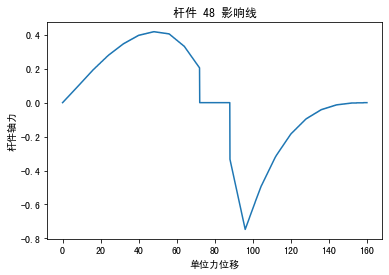

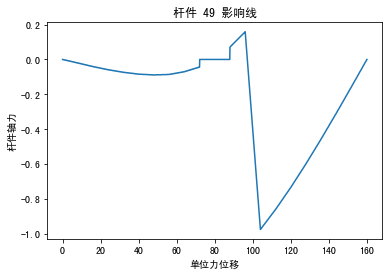

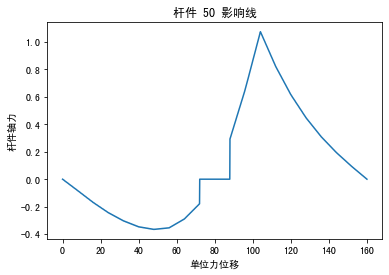

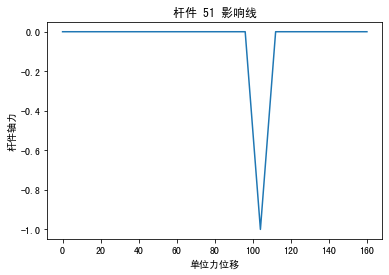

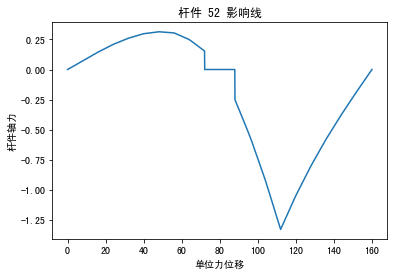

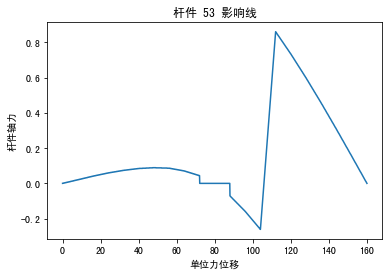

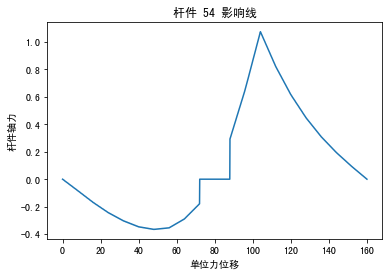

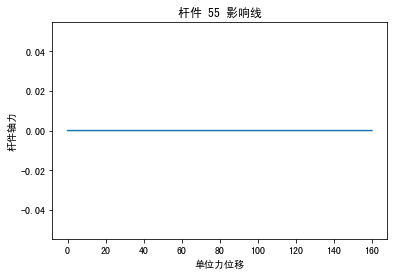

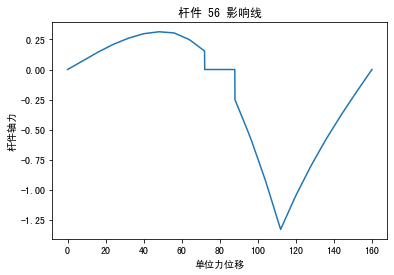

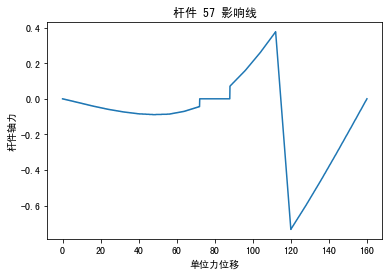

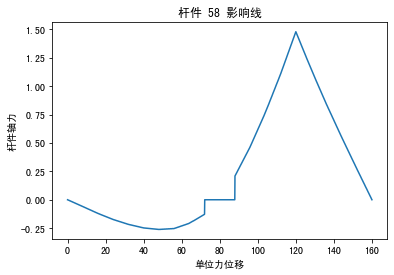

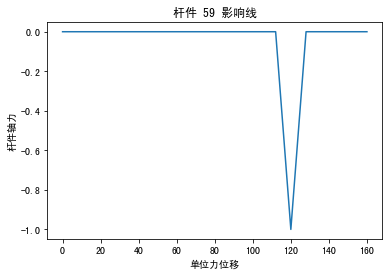

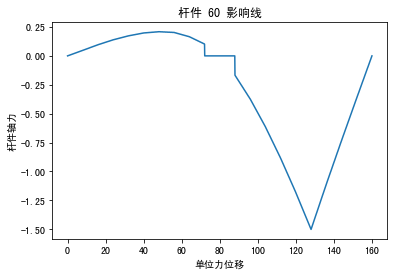

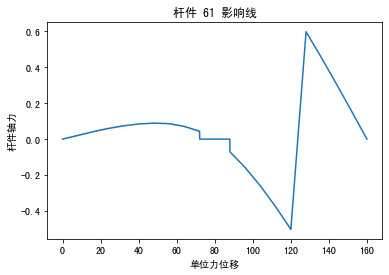

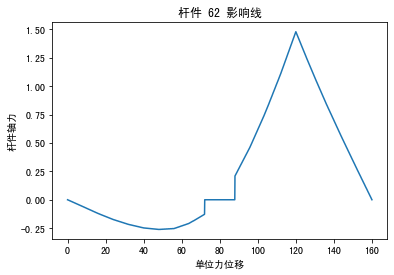

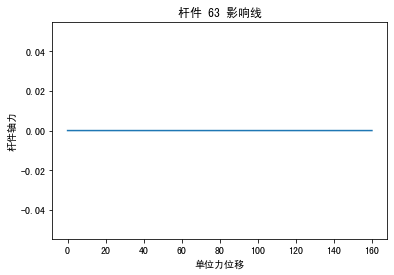

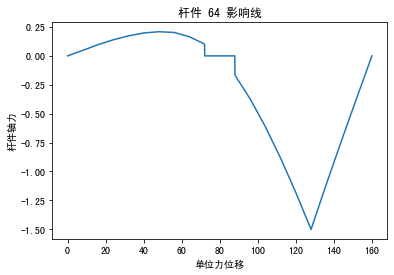

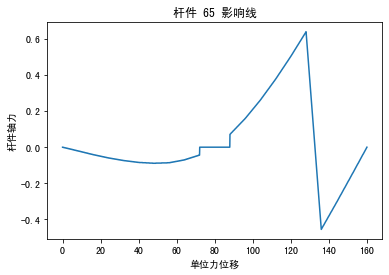

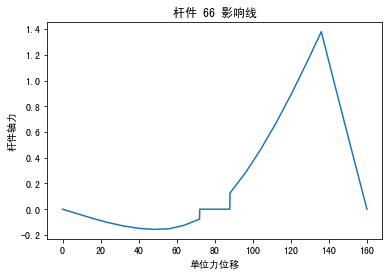

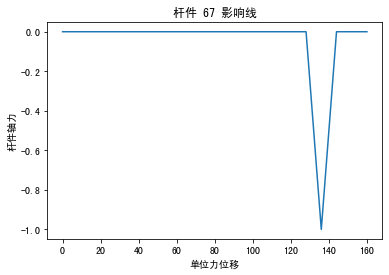

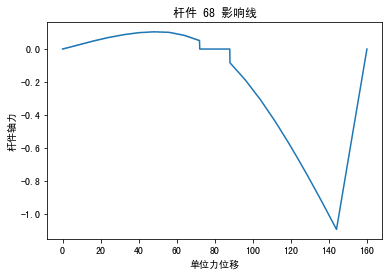

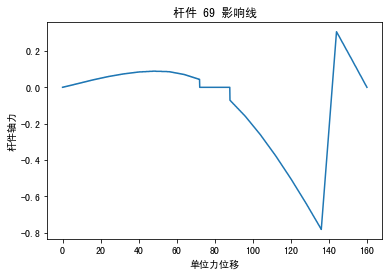

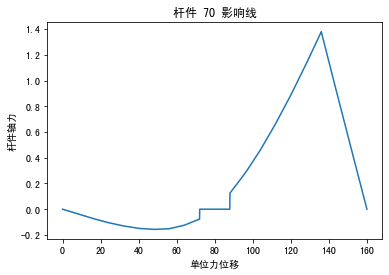

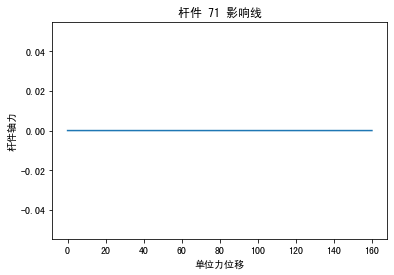

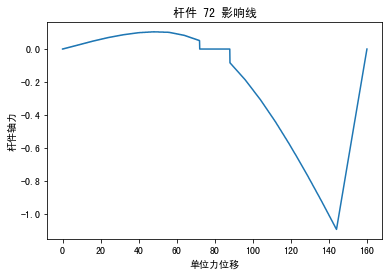

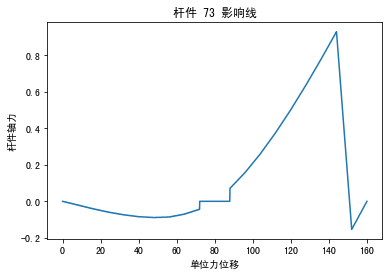

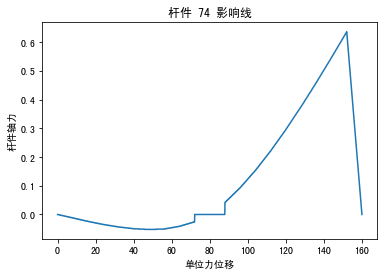

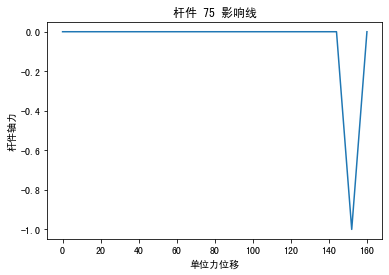

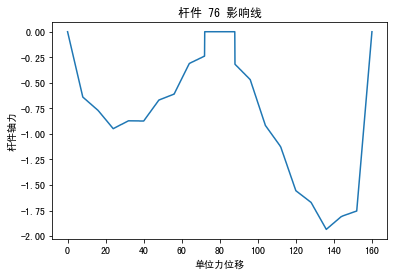

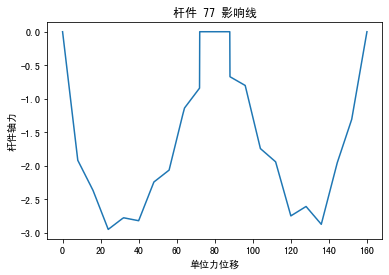

In [25]:
bridge.show_units_axial_forces()

## zk活载

In [19]:
def compute_uniform_load_max(data, load, pos_max, neg_max, right_half):
    
    data = data[::-1] if right_half else data
    pos_data = (data > 0) * data
    neg_data = (data < 0) * data
    
    pos_sum, neg_sum = 0, 0
    for i in range(641 + 1):
        load_selected = list(reversed(load[:i])) if right_half else load[:i]
        selected = np.hstack((load_selected, np.zeros(641 - i)))
        
        #print(i, len(selected), len(pos_data))
        pos_sum = (pos_data * selected).sum()
        neg_sum = (neg_data * selected).sum()
        
        if pos_sum > pos_max:
            pos_max = pos_sum
        if neg_sum < neg_max:
            neg_max = neg_sum
            
    return pos_max, neg_max

def compute_both_load_max(data, load, pos_max, neg_max, right_half):
    # 0:640, 1:641, ..., 352:992
    
    data = data[::-1] if right_half else data
    pos_data = (data > 0) * data
    neg_data = (data < 0) * data
    
    pos_sum, neg_sum = 0, 0
    for i in range(353):
        selected = load[i: i + 641]
        
        pos_sum = (pos_data * selected).sum()
        neg_sum = (neg_data * selected).sum()
        
        if pos_sum > pos_max:
            pos_max = pos_sum
        if neg_sum < neg_max:
            neg_max = neg_sum
            
    return pos_max, neg_max

def compute_unit_worst_cases_load(data, load, pos_max, neg_max, right_half):
    ### 
    pos_max, neg_max = compute_uniform_load_max(data, load, pos_max, neg_max, right_half)
    pos_max, neg_max = compute_both_load_max(data, load, pos_max, neg_max, right_half)
            
    return pos_max, neg_max

def compute_worst_cases_load(F_data, load, units_data):
    for unit, data in F_data.items():
        data = np.array(data)
        load = np.array(load)
        pos_max, neg_max = -np.inf, np.inf

        pos_max, neg_max = compute_unit_worst_cases_load(data, load, pos_max, neg_max, False)  # 左半图
        pos_max, neg_max = compute_unit_worst_cases_load(data, load, pos_max, neg_max, True)       

        units_data[unit]['max_force'] = (pos_max, neg_max)
        
    return units_data

In [ ]:
'''
  6.4/0.1m    0/0.1m         200/0.1m     
  均布荷载      填充           集中荷载                          均布荷载
{| | | | | |}   . . .   {# . 0 . # . 0 . # . 0 . #}   . . .   {| | | | | |}
'''

In [20]:
uniform_load = [6.4 for i in range(641)] # 均布荷载，每个力间隔0.1m
padding = [0 for i in range(int(0.8 / 0.1) - 1)] # 填充0

# 集中荷载，每个间隔0.8m，与均布荷载相距0.8m
conc_load = [200] + padding + [0] + padding + [200] + padding + \
            [0] + padding + [200] + padding + [0] + padding + [200]

load = uniform_load + padding + conc_load + padding + uniform_load

print(len(load))
units_data = compute_worst_cases_load(F_data, load, units_data)

1345


In [21]:
for unit, unit_data in units_data.items():
    print(unit_data['max_force'])

(0.0, -2629.485738641454)
(1546.5890909090665, 0.0)
(833.2800000000004, -3.0995279844300745e-12)
(0.0, -2647.039999999955)
(1980.2999162327055, -90.93201283749407)
(1546.5890909090667, 0.0)
(1.4561475511135743e-12, 0.0)
(0.0, -2647.0399999999545)
(287.9184007235538, -1421.539142760681)
(3309.9636363635736, 0.0)
(833.2800000000074, -3.1163602515355497e-12)
(0.0, -3528.610909090842)
(953.2281481717406, -575.3545674927011)
(3309.9636363635746, 0.0)
(5.327360350188391e-12, -4.4998097808587045e-12)
(0.0, -3528.610909090844)
(953.228148171748, -575.3545674926963)
(3309.963636363572, 0.0)
(833.2799999999977, -3.720293859180462e-12)
(0.0, -2647.0399999999486)
(287.9184007235552, -1421.5391427606796)
(3309.963636363572, 0.0)
(0.0, -5.85370768041559e-12)
(0.0, -2647.0399999999486)
(1980.2999162327046, -90.93201283749445)
(1546.5890909090672, 0.0)
(833.2799999999993, -4.192620911903483e-12)
(0.0, -2629.4857386414483)
(1546.5890909090656, 0.0)


In [62]:
### 疲劳检算 ###
gamma_n = None
gamma_n_ = 1
gamma_n_map = {
    20: 1.000, 16: 1.150, 12: 1.250, 10: 1.300,
     8: 2.400,  5: 1.450,  4: 1.500
}
fixed_load_lens = [20, 16, 12, 10, 8, 5, 4]
gamma_rho_map = {
    -4.5: 0.21, -4.0: 0.23, -3.5: 0.25, -3.0: 0.28,
    -2.0: 0.36, -1.8: 0.38, -1.6: 0.41, -1.4: -0.43,
    -1.2: 0.46, 
}
fixed_rho = [-4.5, -4.0, -3.5, -3.0, -2.0, -1.8, -1.6, -1.4, -1.2]

def inter(map_, x3, x1, x2):
    # 线性插值
    #  x1 < x3 < x2
    y1, y2 = map_(x1), map_(x2)
    return y1 + (x3 - x1) / (x2 - x1) * (y2 - y1)

def get_gamma_n(unit, unit_F_data):
    print(unit)
    unit_F_data = np.around(np.array(unit_F_data), decimals=3)
    unit_F_data_pos_indices = np.where(unit_F_data > 0)[0]
    start = unit_F_data_pos_indices[0] - 1
    end = unit_F_data_pos_indices[-1] + 1
    
    load_len = (end - start) * 0.1  # 影响线加载长度
    if load_len in fixed_load_lens:
        gamma_n = gamma_n_map[load_len]
    
    elif load_len > 20:
        gamma_n =  gamma_n_map[20]
    
    elif load_len < 4:
        gamma_n = gamma_n_map[4]
    
    else:
        for i in range(len(fix_load_lens)):
            if load_len > fixed_load_lens[i]:
                gamma_n = inter(load_len, fixed_load_lens[i], fixed_load_lens[i - 1])
                break
                
    return gamma_n
            

def get_gamma_rho(rho):
    if rho in gamma_rho_map.keys():
        gamma_rho = gamma_rho_map[rho]
    elif rho < -4.5:
        gamma_rho = gamma_rho_map[-4.5]
    elif rho > -1.2:
        gamma_rho = gamma_rho_map[-1.2]
    else:
        for i in range(len(fix_rho)):
            if rho < fixed_rho[i]:
                gamma_rho = inter(rho, fixed_rho[i - 1], fixed_rho[i])
                break
    return gamma_rho


for unit, unit_data in units_data.items():
    sigma_max, sigma_min = np.around(unit_data['max_force'], decimals=3)
    if sigma_max == 0 and sigma_min == 0:   # 力都为0
        units_data[unit]['qualified'] = True
        continue
    elif sigma_max == 0 and sigma_min < 0:
        rho = -float('inf')
    else:
        rho = sigma_min / sigma_max
    
    if rho >= -1:
        gamma_n = get_gamma_n(unit, F_data[unit])
        if gamma_d * gamma_n * (sigma_max - sigma_min) < gamma_t * sigma_0:
            units_data[unit]['qualified'] = True
        else:
            units_data[unit]['qualified'] = False
    else:
        gamma_rho = get_gamma_rho(rho)
        if gamma_d * gamma_n_ * sigma_max <= gamma_t * gamma_rho * sigma_0:
            units_data[unit]['qualified'] = True
        else:
            False
    

2
3
5
6
10
11
13
14
17
18
19
22
25
26
27
29


In [64]:
for unit, unit_data in units_data.items():
    print('Qualified: ', unit_data['qualified'])

Qualified:  True
Qualified:  True
Qualified:  True
Qualified:  True
Qualified:  True
Qualified:  True
Qualified:  True
Qualified:  True
Qualified:  True
Qualified:  True
Qualified:  True
Qualified:  True
Qualified:  True
Qualified:  True
Qualified:  True
Qualified:  True
Qualified:  True
Qualified:  True
Qualified:  True
Qualified:  True
Qualified:  True
Qualified:  True
Qualified:  True
Qualified:  True
Qualified:  True
Qualified:  True
Qualified:  True
Qualified:  True
Qualified:  True


In [42]:
### 计算杆件单元恒载内力 ###
h_vec = np.zeros((1, 641))
h_vec.fill(1)
for unit, data in F_data.items():
    internal_force = (h_vec * data).sum()
    units_data[unit]['internal_force'] = internal_force
    
for unit, unit_data in units_data.items():
    print(unit_data['internal_force'])

-346.21924931325987
203.6363636363601
79.99999999999979
-349.0909090909028
247.2994637951846
203.63636363636013
1.9665595831685243e-13
-349.09090909090264
-148.379678277111
436.3636363636278
80.00000000000054
-465.45454545453634
49.459892759036634
436.36363636362785
7.105427357601002e-15
-465.4545454545365
49.4598927590381
436.3636363636277
79.99999999999967
-349.0909090909021
-148.37967827711068
436.3636363636276
-5.092947620512964e-13
-349.090909090902
247.2994637951845
203.6363636363602
79.99999999999952
-346.21924931325907
203.63636363635996


### 测试👇

In [11]:
print(zip([1, 2], [3, 4]))